### Data
We want sequence that are long enough where there is room to forget token kvs with minimal information loss.

In [2]:
from tqdm.auto import tqdm
from datasets import load_dataset
import numpy as  np
from transformers import GPT2Tokenizer

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
dataset = load_dataset('wikitext', 'wikitext-103-v1')
split = dataset['train']

In [ ]:
# compute text with token length >= 512
batch = 500
min_tok_length = 512
filtered = []
lengths = []
max_length = 0
for i in tqdm(range(0, len(split), batch)):
    lengths += [len(tok) for tok in tokenizer.batch_encode_plus([split[min(i+j, len(split) - 1)]['text'] for j in range(batch)])['input_ids']]

In [34]:
np.save('token_length.npy', np.array(lengths))

In [174]:
l = np.load('token_length.npy')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
all([len(tok) > 512 for tok in tokenizer.batch_encode_plus([split[int(i)]['text'] for i in np.where(l > 512)[0][:20]])['input_ids']])

True

Text(0.5, 1.0, 'num sequences with L > x')

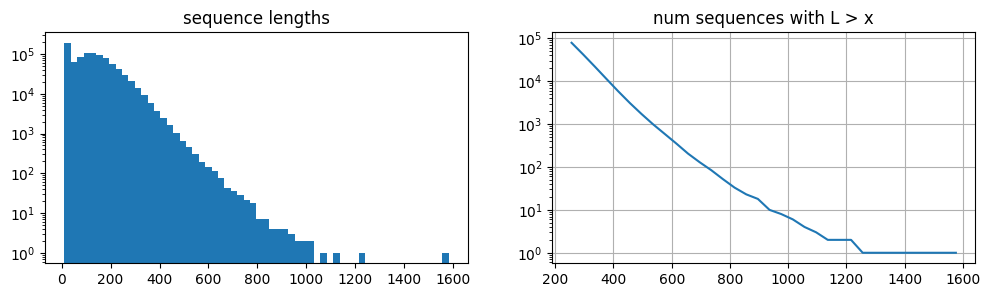

In [30]:
_, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].hist(l[l > 10], bins=60)
ax[0].set_yscale('log')
ax[0].set_title('sequence lengths')

tot = []
step = 40
r = range(256, l.max(), step)
ax[1].plot(r, [(l>i).sum() for i in r])
ax[1].grid()
ax[1].set_yscale('log')
ax[1].set_title('num sequences with L > x')

In [214]:
(l > 400).sum()

7626

### Analyis
Study sensitivity in relation to ratio of forgotten kvs as well as timestep of pruning start.

Test pruning (no-FT) based on:
- similarity of k
- similarity of v
- min(sim_k, sim_v)
- cumulative attention weights
- Mix of above

Visualize ppl by number of tokens pruned, both with and without intermediate renormalization


### Apply to MHA (GPT2 WikiText)

In [274]:
import torch
import torch.nn as nn
import numpy as np
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import transformers_drop_in as drop_in
import tensor_util as tu
from config import CONFIG

In [273]:
CONFIG.do_consolidate = True
CONFIG.consolidate_ratio = 0.5
CONFIG.context_length = 400
CONFIG.consolidate_length = 200
CONFIG.temperature = 0.1
CONFIG.fix_prune_rate = True

In [592]:
a = torch.arange(20).view(2, 10)
np.random.randint(0, 10, (2,5))

array([[9, 1, 2, 0, 2],
       [5, 0, 9, 7, 8]])

In [612]:
n =10
np.arange(n, 0, -1)

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [615]:
torch.arange(n, 0, -1)

tensor([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [614]:
np.array([0.7]).astype(int)

array([0])

### Trying to figure out how to sample without replacement by scaling and sorting random vectors

In [694]:
n = 2
p = np.arange(1, n + 1)
p = p / p.sum()

In [677]:
p

array([0.33333333, 0.66666667])

In [658]:
np.log(p *10)

array([-1.70474809, -1.01160091, -0.6061358 , -0.31845373, -0.09531018,
        0.08701138,  0.24116206,  0.37469345,  0.49247649,  0.597837  ])

In [659]:
np.log(p * 100)

array([0.597837  , 1.29098418, 1.69644929, 1.98413136, 2.20727491,
       2.38959647, 2.54374715, 2.67727854, 2.79506158, 2.90042209])

In [642]:
np.log(p, np.ones(n) * 10)

array([-4.00733319, -3.314186  , -2.9087209 , -2.62103882, -2.39789527,
       -2.21557372, -2.06142304, -1.92789164, -1.81010861, -1.70474809])

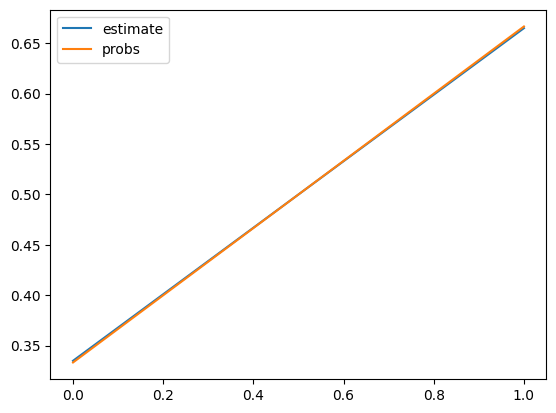

In [696]:
samples = np.zeros_like(p)
for i in range(100000):
    sample = -np.log(np.random.rand(n)) * p
    i = sample.argmax()
    samples[i] += 1
r = samples / 100000
plt.plot(r, label="estimate")
plt.plot(p, label="probs")
plt.legend()

In [617]:
n = 10
perm_arr = (torch.Tensor(np.random.rand(n)) * torch.arange(n, 0, -1)).type(torch.int)

In [618]:
perm_arr

tensor([3, 5, 2, 4, 5, 2, 1, 0, 1, 0], dtype=torch.int32)

In [622]:
perm_matrix = torch.arange(n)[None] > perm_arr[:,None]
print(perm_matrix)   # i,j = True => sample j needs to be shifted left one due to an element before it being sampled at step i

perm_matrix = perm_matrix.cumsum(dim=0)
perm_matrix   # i,j = n => sample j needs to be shifted left n spaces at step i

tensor([[False, False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True]])


tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1],
        [ 0,  0,  0,  0,  1,  1,  2,  2,  2,  2],
        [ 0,  0,  0,  1,  2,  2,  3,  3,  3,  3],
        [ 0,  0,  0,  1,  2,  3,  4,  4,  4,  4],
        [ 0,  0,  0,  1,  2,  3,  5,  5,  5,  5],
        [ 0,  0,  0,  2,  3,  4,  6,  6,  6,  6],
        [ 0,  0,  1,  3,  4,  5,  7,  7,  7,  7],
        [ 0,  1,  2,  4,  5,  6,  8,  8,  8,  8],
        [ 0,  1,  3,  5,  6,  7,  9,  9,  9,  9],
        [ 0,  2,  4,  6,  7,  8, 10, 10, 10, 10]])

In [599]:
def sample(tensor, n_samples, dim=-1):
    """Samples from the given tensor of normalized likelihoods along the given dimension"""
    upper_bound = tensor.cumsum(dim=dim)
    lower_bound = torch.cat(
        [
            torch.zeros(
                tuple(d if dim % len(tensor.shape) != i else 1 for i, d in enumerate(tensor.shape)),
                dtype=upper_bound.dtype,
                device=upper_bound.device,
            ),
            upper_bound[
                tuple(slice(None) if dim % len(tensor.shape) != i else slice(-1) for i in range(len(tensor.shape)))
            ],
        ],
        dim=dim,
    )
    n_broadcast = np.array([d for i, d in enumerate(tensor.shape) if dim % len(tensor.shape) != i]).prod()
    
    # expand bound tensors to add sample dimension
    upper_bound = upper_bound.unsqueeze(-1)
    lower_bound = lower_bound.unsqueeze(-1)
    
    # sample
    samples = np.random.rand(
        *(d if dim % len(tensor.shape) != i else 1 for i, d in enumerate(tensor.shape)), n_samples
    )
    samples = torch.Tensor(samples).to(upper_bound.device)
    
    return np.where(
        torch.bitwise_and(samples >= lower_bound, samples < upper_bound).cpu()  # [ ... X sample dim X ... X n samples ]
    )[:-1]    

def test_sample(tensor, dim=-1, n_samples=10000):
    totals = torch.zeros_like(tensor, device=tensor.device)
    for i in range(n_samples):
        totals[sample(tensor, 1, dim=dim)] += 1
    return (totals / n_samples - tensor).abs()

In [609]:
n = 1
tots = torch.zeros_like(tensor)
print(tensor)
for i in range(10000):
    tots[sample(tensor, n)] += 1
print(tots /10000)
(tots / 10000 - tensor)

tensor([[[0.0000, 0.2079, 0.3465, 0.4455],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2842, 0.2558, 0.2368, 0.2233]],

        [[0.2434, 0.2481, 0.2524, 0.2562],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2542, 0.2512, 0.2485, 0.2461]]])
tensor([[[0.0000, 0.2055, 0.3424, 0.4521],
         [0.2506, 0.2474, 0.2445, 0.2575],
         [0.2780, 0.2631, 0.2370, 0.2219]],

        [[0.2480, 0.2414, 0.2519, 0.2587],
         [0.2529, 0.2420, 0.2508, 0.2543],
         [0.2530, 0.2552, 0.2481, 0.2437]]])


tensor([[[ 0.0000, -0.0024, -0.0041,  0.0066],
         [ 0.0006, -0.0026, -0.0055,  0.0075],
         [-0.0062,  0.0073,  0.0002, -0.0014]],

        [[ 0.0046, -0.0067, -0.0005,  0.0025],
         [ 0.0029, -0.0080,  0.0008,  0.0043],
         [-0.0012,  0.0040, -0.0004, -0.0024]]])

In [266]:
a = torch.arange(24).view(2, 3, 4).type(torch.float)
print(a)
torch.quantile(a, 0.5, dim=-1)

tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]],

        [[12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.]]])


tensor([[ 1.5000,  5.5000,  9.5000],
        [13.5000, 17.5000, 21.5000]])

In [272]:
a = torch.zeros(2, 4, 4)
a[:,torch.arange(4), torch.arange(4)]

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [264]:
a = torch.arange(16).view(4, 4).type(torch.float)
attn = torch.matmul(a, a.T)
attn = nn.functional.softmax(attn, dim=-1)
attn


tensor([[5.3802e-32, 1.4252e-21, 3.7751e-11, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 6.0546e-39, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]])

In [265]:
a.diag()

tensor([ 0.,  5., 10., 15.])

In [308]:
tensor = torch.arange(24).view(2, 3, 4)
dim = 1
tensor[tuple(slice(None) if dim % len(tensor.shape) != i else slice(-1) for i in range(len(tensor.shape)))]

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19]]])

In [305]:
torch.zeros((i for i in range(2)))

TypeError: zeros(): argument 'size' (position 1) must be tuple of ints, but found element of type generator at pos 0

In [575]:
def sample(tensor, n_samples, dim=-1):
    """Samples from the given tensor of normalized likelihoods along the given dimension"""
    upper_bound = tensor.cumsum(dim=dim)
    lower_bound = torch.cat(
        [
            torch.zeros(
                tuple(d if dim % len(tensor.shape) != i else 1 for i, d in enumerate(tensor.shape)),
                dtype=upper_bound.dtype,
                device=upper_bound.device,
            ),
            upper_bound[
                tuple(slice(None) if dim % len(tensor.shape) != i else slice(-1) for i in range(len(tensor.shape)))
            ],
        ],
        dim=dim,
    )
    n_broadcast = np.array([d for i, d in enumerate(tensor.shape) if dim % len(tensor.shape) != i]).prod()
    
    # expand bound tensors to add sample dimension
    upper_bound = upper_bound.unsqueeze(-1)
    lower_bound = lower_bound.unsqueeze(-1)
    
    # sample
    samples = np.random.rand(
        *(d if dim % len(tensor.shape) != i else 1 for i, d in enumerate(tensor.shape)), n_samples
    )
    samples = torch.Tensor(samples).to(upper_bound.device)
    
    return np.where(
        torch.bitwise_and(samples >= lower_bound, samples < upper_bound).cpu()  # [ ... X sample dim X ... X n samples ]
    )[:-1]
sample(tensor, 2, dim=2)[-1]

array([2, 3, 1, 2, 1, 2, 0, 2, 1, 3, 1, 2])

In [313]:
a = torch.arange(6).view(2, 3, 1)
b = torch.arange(8).view(2, 1, 4)
print(a)
print(b)
(a == b)

tensor([[[0],
         [1],
         [2]],

        [[3],
         [4],
         [5]]])
tensor([[[0, 1, 2, 3]],

        [[4, 5, 6, 7]]])


tensor([[[ True, False, False, False],
         [False,  True, False, False],
         [False, False,  True, False]],

        [[False, False, False, False],
         [ True, False, False, False],
         [False,  True, False, False]]])

In [317]:
print(tensor.shape)
tensor[(*(slice(None) for _ in range(len(tensor.shape))), None)].shape
tensor.unsqueeze(-1).shape

torch.Size([2, 3, 4])


torch.Size([2, 3, 4, 1])

In [319]:
torch.Tensor(np.array([1,2]))

tensor([1., 2.])

In [ ]:
torch

In [321]:
tuple([1, 2, 3])[:-1]

(1, 2)

In [350]:
dim = 1
tensor = torch.arange(24).view(2, 3, 4)
tensor = tensor /tensor.sum(dim=dim)[:,None]
tensor.shape

torch.Size([2, 3, 4])

In [354]:
upper_bound = tensor.cumsum(dim=dim)
a = torch.zeros(
        tuple(d if dim % len(tensor.shape) != i else 1 for i, d in enumerate(tensor.shape)),
        dtype=upper_bound.dtype,
        device=upper_bound.device,
    )
b = upper_bound[
        tuple(slice(None) if dim % len(tensor.shape) != i else slice(-1) for i in range(len(tensor.shape)))
    ]

In [355]:
upper_bound.shape, a.shape, b.shape

(torch.Size([2, 3, 4]), torch.Size([2, 1, 4]), torch.Size([2, 2, 4]))

In [338]:
w = torch.bitwise_and(samples >= lower_bound, samples < upper_bound).cpu()

In [344]:
np.where(w)[:-1]

(array([1, 2, 2, 3, 4]),)

In [358]:
len(np.where(samples))

4

In [359]:
samples.shape

torch.Size([6, 1, 6, 3])

In [426]:
s = torch.zeros_like(tensor, dtype=torch.bool)
sample_no_replace(tensor, 1)[0]


array([0, 0, 1, 1, 1])

In [494]:
dim = 2
n_samples = 1

In [580]:
x = torch.zeros_like(tensor, dtype=torch.bool)
x[sample(tensor, 1, dim=2)] = True
x

tensor([[[False, False,  True, False],
         [False,  True, False, False],
         [False, False, False,  True]],

        [[False,  True, False, False],
         [False, False, False,  True],
         [False, False,  True, False]]])

In [543]:
tensor = tensor / tensor.sum(2)[:,:,None]


In [531]:
lower_bound[:,:,:,0]

tensor([[[0.0000, 0.0000, 0.0667, 0.1778],
         [0.0000, 0.3333, 0.6667, 1.0000],
         [0.0000, 0.6667, 1.2667, 1.8222]],

        [[0.0000, 0.2500, 0.5049, 0.7642],
         [0.0000, 0.3333, 0.6667, 1.0000],
         [0.0000, 0.4167, 0.8284, 1.2358]]])

In [537]:
upper_bound[:,:,:,0]

tensor([[[0.0000, 0.0667, 0.1778, 0.3206],
         [0.3333, 0.6667, 1.0000, 1.3333],
         [0.6667, 1.2667, 1.8222, 2.3460]],

        [[0.2500, 0.5049, 0.7642, 1.0273],
         [0.3333, 0.6667, 1.0000, 1.3333],
         [0.4167, 0.8284, 1.2358, 1.6393]]])

In [536]:
print(samples[:,:,:,0])
print(samples[:,:,:,0] >= lower_bound[:,:,:,0])
print(samples[:,:,:,0] < upper_bound[:,:,:,0])

tensor([[[0.4132],
         [0.9657],
         [0.4553]],

        [[0.8992],
         [0.1104],
         [0.0833]]])
tensor([[[ True,  True,  True,  True],
         [ True,  True,  True, False],
         [ True, False, False, False]],

        [[ True,  True,  True,  True],
         [ True, False, False, False],
         [ True, False, False, False]]])
tensor([[[False, False, False, False],
         [False, False,  True,  True],
         [ True,  True,  True,  True]],

        [[False, False, False,  True],
         [ True,  True,  True,  True],
         [ True,  True,  True,  True]]])


In [521]:
y = torch.bitwise_and(samples >= lower_bound, samples < upper_bound)

In [523]:
x.sum(), y.sum()

(tensor(5), tensor(6))

In [524]:
tensor.shape

torch.Size([2, 3, 4])

In [365]:
def sample_no_replace(tensor, n_samples, dim=-1):
    """Samples from the given tensor of normalized likelihoods along the given dimension"""
    upper_bound = tensor.cumsum(dim=dim)
    lower_bound = torch.cat(
        [
            torch.zeros(
                tuple(d if dim % len(tensor.shape) != i else 1 for i, d in enumerate(tensor.shape)),
                dtype=upper_bound.dtype,
                device=upper_bound.device,
            ),
            upper_bound[
                tuple(slice(None) if dim % len(tensor.shape) != i else slice(-1) for i in range(len(tensor.shape)))
            ],
        ],
        dim=dim,
    )
    n_broadcast = np.array([d for i, d in enumerate(tensor.shape) if dim % len(tensor.shape) != i]).prod()
    
    # expand bound tensors to add sample dimension
    upper_bound = upper_bound.unsqueeze(-1)
    lower_bound = lower_bound.unsqueeze(-1)
    
    # sample
    samples = np.random.rand(
        *(d if dim % len(tensor.shape) != i else 1 for i, d in enumerate(tensor.shape)), n_samples
    )
    samples = torch.Tensor(samples).to(upper_bound.device)

    return np.where(
        torch.bitwise_and(samples >= lower_bound, samples < upper_bound).cpu()  # [ ... X sample dim X ... X n samples ]
    )[:-1]

In [293]:
x = torch.arange(5) + 1
x = x/x.sum()
x.cumsum(dim=0)
x[:-1]

tensor([0.0667, 0.1333, 0.2000, 0.2667])

In [ ]:
def consolidate_v1(key, value, token_mask):
    prune_rate = int(CONFIG.context_length * CONFIG.consolidate_ratio)
    
    # compute K-similatiy
    ksim = torch.matmul(key, key.transpose(-1, -2))
    ksim = nn.functional.softmax(ksim / CONFIG.temperature, dim=-1, t)

    # propagate values
    consolidate_v = torch.matmul(ksim, value)

    # prune proportionally to diffusion rate (normalized K-sim weight placed on other keys)
    tok_idx = torch.arange(ksim.size(0))
    diffusion_rate = 1 - ksim[:,:,tok_idx,tok_idx]

    # sample
    # 1. randomly permute sample rate array
    # 2. 
    
    # TODO scale diffusion rate tensor to enforce prune ratio
    prune_mask = torch.bernoulli(diffusion_rate).type(torch.bool)  # [ batch X n heads X length ]
    
    return key[:,], consolidate_v

drop_in.consolidate_kv = consolidate_v1

In [ ]:
from config import CONFIG


In [234]:
cns_l = 5
new_l = 4
d = 6
(torch.matmul(torch.zeros(2, 3, cns_l, new_l), torch.zeros(2, 3, new_l, d)) * torch.zeros(2,3,cns_l, d)).shape

torch.Size([2, 3, 5, 6])

In [240]:
from config import CONFIG
k = torch.zeros(2, 3, 400, 10)
v = torch.zeros(2, 3, 400, 10)
k, v = consolidate_kv_cache(k, v)

In [241]:
k.shape, v.shape

(torch.Size([2, 3, 150, 10]), torch.Size([2, 3, 150, 10]))

In [236]:
# Define consolidation logic
def consolidate_v1(key, value):
    consolidate_k = key[:,:,:CONFIG.consolidate_length]  # fixed key set into which we allow consolidation
    
    # compute K-sim between fixed key set and new token keys
    ksim = torch.matmul(
        consolidate_k,
        key[:,:,CONFIG.consolidate_length:CONFIG.context_length].transpose(-1, -2),  # new tokens to consolidate
    )  # [ batch X n heads X consolidate length X new token length ]

    # TODO use softmax temp with self-sim to determine how much value consolidation into non-equivalent keys is allowed
    ksim = nn.functional.softmax(ksim, dim=-1)

    # TODO track cumulative consolidation weight for each key in fixed set

    consolidate_v = torch.matmul(ksim, value[:,:,CONFIG.consolidate_length:CONFIG.context_length])  # [ batch X n heads X consolidate length X d ]

    return consolidate_k, consolidate_v

# TODO
# - add self-attention within both fixed and new key sets and isolate keys with high self-similarity

# TODO use A-sim (similarity in attention weight pattern)
def consolidate_v2(key, value):
    


drop_in.consolidate_kv = consolidate_v1

In [12]:
a = torch.arange(24).view(2, 3, 4)
b = a.topk(2, dim=2)

In [26]:
sorted(map(int, a[torch.arange(2).repeat_interleave(3).repeat_interleave(2),
  torch.arange(3).repeat(2).repeat_interleave(2),
  b.indices.flatten()]))

[2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23]

In [17]:
sorted(map(int, b.values.flatten()))

[2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23]

In [20]:
b.indices

tensor([[[3, 2],
         [3, 2],
         [3, 2]],

        [[3, 2],
         [3, 2],
         [3, 2]]])

In [25]:
(torch.arange(2).repeat_interleave(3).repeat_interleave(2),
torch.arange(3).repeat(2).repeat_interleave(2))

(tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]),
 tensor([0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2]))

In [19]:
a  # (0,0,0,0,0,0,1,1,1,1,1,1), (0,0,1,1,2,2,0,0,1,1,2,2), (3,2,3,2,3,2,3,2,3,2,3,2)

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])

In [18]:
b

torch.return_types.topk(
values=tensor([[[ 3,  2],
         [ 7,  6],
         [11, 10]],

        [[15, 14],
         [19, 18],
         [23, 22]]]),
indices=tensor([[[3, 2],
         [3, 2],
         [3, 2]],

        [[3, 2],
         [3, 2],
         [3, 2]]]))

In [29]:
torch.ones(2).reshape(1,2)

tensor([[1., 1.]])

In [32]:
np.array([2,4]).prod()b

8

In [38]:
(np.
 array(1))

array(1)

In [53]:
np.random.choice(torch.arange(10), 10, replace=False)

array([2, 4, 9, 5, 6, 3, 0, 8, 1, 7])

In [79]:
*a, _ = 1, 3,2

In [78]:
type(a)

list

In [94]:
def get_tensor_elem_idx(*dims):
    if not isinstance(dims, np.ndarray):
        dims = np.array(dims)
    return tuple(
        torch.arange(dims[i])
            .repeat(dims[:i].prod())
            .repeat_interleave(dims[i+1:].prod())
        for i in range(len(dims))
    )

def sample_elem_idx(tensor, sample_size):
    idxs = get_tensor_elem_idx(*tensor.shape)
    idx_tensor = torch.stack(idxs)  # [ n dims X n elements ]
    sample_elems = torch.randperm(tensor.numel())[:sample_size]
    return tuple(idx_tensor[:,sample_elems])

def topk(tensor, k, dim=-1):
    idx_tensor = tensor.topk(k, dim=dim).indices
    *indices, _ = get_tensor_elem_idx(*idx_tensor.shape)
    return *indices, idx_tensor.flatten()

In [ ]:
def test_

In [87]:
x = torch.arange(24).view(2,3,4)

In [98]:
sorted(x[topk(x, 2)])

[tensor(2),
 tensor(3),
 tensor(6),
 tensor(7),
 tensor(10),
 tensor(11),
 tensor(14),
 tensor(15),
 tensor(18),
 tensor(19),
 tensor(22),
 tensor(23)]

In [97]:
sorted(x.topk(2).values.flatten())

[tensor(2),
 tensor(3),
 tensor(6),
 tensor(7),
 tensor(10),
 tensor(11),
 tensor(14),
 tensor(15),
 tensor(18),
 tensor(19),
 tensor(22),
 tensor(23)]

In [85]:
x.topk()

torch.return_types.topk(
values=tensor([], dtype=torch.int64),
indices=tensor([], dtype=torch.int64))

In [74]:
torch.arange(24).view(2,3,4).topk(1, dim=1).indices

tensor([[[2, 2, 2, 2]],

        [[2, 2, 2, 2]]])

In [279]:
a = torch.zeros(2, 3, 4)
ix = sample_elem_idx((2,3, 4), 3)
a[ix] = 1
a

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [1., 0., 1., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 0.]]])

In [106]:
ksim = torch.arange(12 * 400 * 400).reshape(1, 12, 400, 400)
batch_range = torch.arange(ksim.size(0)).to(DEVICE)

# put into [ batch X n heads X L_p^2 ] for top-k computation
ksim_flat = ksim.view(-1, n_heads_, L_p_ ** 2)

In [115]:
L_p_

200

In [112]:
ksim_flat.topk(PRUNE_K, dim=-1).values.shape

torch.Size([4, 12, 50])

In [114]:
ksim_flat.shape

torch.Size([4, 12, 40000])

In [ ]:
topk(ksim_flat, PRUNE_K, dim=-1)

In [117]:
x = compute_topk(torch.arange(12 * 400 * 400).reshape(1, 12, 400, 400))

In [118]:
x[0].shape

torch.Size([600])

In [45]:
torch.ones(2,3,4)[get_tensor_elem_idx(2,3,4)]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])

In [148]:
torch.tril(torch.ones(2, 2), diagonal=0)

tensor([[1., 0.],
        [1., 1.]])

In [180]:
torch.arange(24).view(2, 3,4) / torch.arange(6).view(2, 3)[:,:,None]

tensor([[[   nan,    inf,    inf,    inf],
         [4.0000, 5.0000, 6.0000, 7.0000],
         [4.0000, 4.5000, 5.0000, 5.5000]],

        [[4.0000, 4.3333, 4.6667, 5.0000],
         [4.0000, 4.2500, 4.5000, 4.7500],
         [4.0000, 4.2000, 4.4000, 4.6000]]])

In [211]:
a = torch.arange(24 * 4).view(2, 3, 4, 4).type(torch.float)
e_ksim = torch.exp(a)
p_ksim = e_ksim / (e_ksim.sum(dim=-1)[:,:,:,None])
a == nn.functional.softmax(a, dim=-1)
nn.functional.softmax(a, dim=-1).sum(dim=-1)

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

In [212]:
DEVICE = 0
PRUNE_RANGE = 0, 200
LOSS_RANGE = 200, 400
DO_PRUNE = False
PRUNE_K = 50  # effectively the number of tokens we prune + 1
STORE_SIM = True
KSIM_OUTPUT_BY_LAYER = {
    "ksim": {},
    "kwise_other_k_weight": {},
    "kwise_other_q_weight": {},
    "kwise_avg_ksim": {},  # TODO
}
SAMPLE_KSIM = 10000
SOFTMAX_EPS = 1e-10

L = LOSS_RANGE[1]
L_p_ = PRUNE_RANGE[1] - PRUNE_RANGE[0]
n_heads_ = 12
d_ = 64

# define mask and index tensors
ksim_mask_ = torch.tril(torch.ones((L_p_, L_p_), device=DEVICE), diagonal=0).type(torch.bool)  # [ L_p X L_p ]


def build_L_square_idx(L):
    x = torch.arange(L, device=DEVICE)[None].repeat(L, 1)
    return torch.stack([x, x.T]).reshape(L ** 2, 2)  # [ L^2 X 2 ]
    

def compute_topk(ksim):
    """Shapes:
    key_sim:   torch.Size([batch, n heads, L_p, L_p])
    """
    batch, n_heads, L, _ = ksim.shape
    L_square_idx = build_L_square_idx(L)

    batch_range = torch.arange(batch).to(DEVICE)

    # put into [ batch X n heads X L^2 ] for top-k computation
    ksim_flat = ksim.view(-1, n_heads, L ** 2)

    # compute top-k similar keys across tokens in prune span per attention head
    batch_idx, attn_head_idx, key_pair_idx = topk(ksim_flat, PRUNE_K, dim=-1)

    # put indices back into [ batch X n heads X L X L ]
    pos_1, pos_2 = L_square_idx[key_pair_idx].T

    return batch_idx, attn_head_idx, pos_1, pos_2


def compute_ksim(key):
    ksim = torch.matmul(key, key.transpose(-1, -2))  # [ batch X n heads X L_p X L_p ]
    #ksim[:,:,ksim_mask_] = float('-inf')
    return ksim


def compute_asim(key):
    pass


def prune(module, query, key, value, attention_mask=None, head_mask=None):
    """Shapes:
    query:          torch.Size([batch, n heads, L, d])
    key:            torch.Size([batch, n heads, L, d])
    value:          torch.Size([batch, n heads, L, d])
    attention_mask: torch.Size([batch, 1, 1, L])
    """

    # compute key similarities
    if DO_PRUNE or STORE_SIM:
        pruneable_keys = key[:,:,PRUNE_RANGE[0]:PRUNE_RANGE[1]]
        ksim = compute_ksim(pruneable_keys)  # [ batch X n heads X L_p X L_p ]

        if STORE_SIM:
            # sample k-sims
            KSIM_OUTPUT_BY_LAYER["ksim"][module.layer_idx] = np.random.choice(ksim[:,:,~ksim_mask_].cpu().flatten(), SAMPLE_KSIM)

            # key-wise entropy of k-sim
            # e_ksim = torch.exp(ksim)
            # p_ksim = e_ksim / (e_ksim.sum(dim=-1)[:,:,:,None])
            p_ksim = nn.functional.softmax(ksim, dim=-1)
            mask_diag = torch.zeros(p_ksim.size(-1), p_ksim.size(-1)).type(torch.bool)
            mask_diag.fill_diagonal_(True)
            p_ksim[:,:,mask_diag] = 0
            
            KSIM_OUTPUT_BY_LAYER["kwise_other_k_weight"][module.layer_idx] = p_ksim.sum(dim=-1).cpu().flatten()

        if DO_PRUNE:
            #where_topk = compute_topk(ksim)
            
            # greedy sampling, make sure to leave one token for each k-equivalency class

            # consolidation by weighted key-summation

            # isolate current-key by new-key block of the k-sim matrix

            # 
        
    
    return query, key, value


# modified _attn https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py#L182
def drop_in_attn(self, query, key, value, attention_mask=None, head_mask=None):

    #########################
    # prune before attention

    query, key, value = prune(self, query, key, value, attention_mask, head_mask)
    
    #########################
    
    attn_weights = torch.matmul(query, key.transpose(-1, -2))

    if self.scale_attn_weights:
        attn_weights = attn_weights / torch.full(
            [], value.size(-1) ** 0.5, dtype=attn_weights.dtype, device=attn_weights.device
        )

    # Layer-wise attention scaling
    if self.scale_attn_by_inverse_layer_idx:
        attn_weights = attn_weights / float(self.layer_idx + 1)

    if not self.is_cross_attention:
        # if only "normal" attention layer implements causal mask
        query_length, key_length = query.size(-2), key.size(-2)
        causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length]
        mask_value = torch.finfo(attn_weights.dtype).min
        # Need to be a tensor, otherwise we get error: `RuntimeError: expected scalar type float but found double`.
        # Need to be on the same device, otherwise `RuntimeError: ..., x and y to be on the same device`
        mask_value = torch.full([], mask_value, dtype=attn_weights.dtype).to(attn_weights.device)
        attn_weights = torch.where(causal_mask, attn_weights.to(attn_weights.dtype), mask_value)

    if attention_mask is not None:
        # Apply the attention mask
        attn_weights = attn_weights + attention_mask

    attn_weights = nn.functional.softmax(attn_weights, dim=-1)

    # Downcast (if necessary) back to V's dtype (if in mixed-precision) -- No-Op otherwise
    attn_weights = attn_weights.type(value.dtype)
    attn_weights = self.attn_dropout(attn_weights)

    # Mask heads if we want to
    if head_mask is not None:
        attn_weights = attn_weights * head_mask

    attn_output = torch.matmul(attn_weights, value)

    return attn_output, attn_weights

GPT2Attention._attn = drop_in_attn

In [120]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(DEVICE)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [177]:
batch_size = 1
indices, = np.where(l > LOSS_RANGE[1])
batch_iter = iter(np.array_split(np.random.choice(indices, len(indices), replace=False), len(indices) // batch_size))

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline

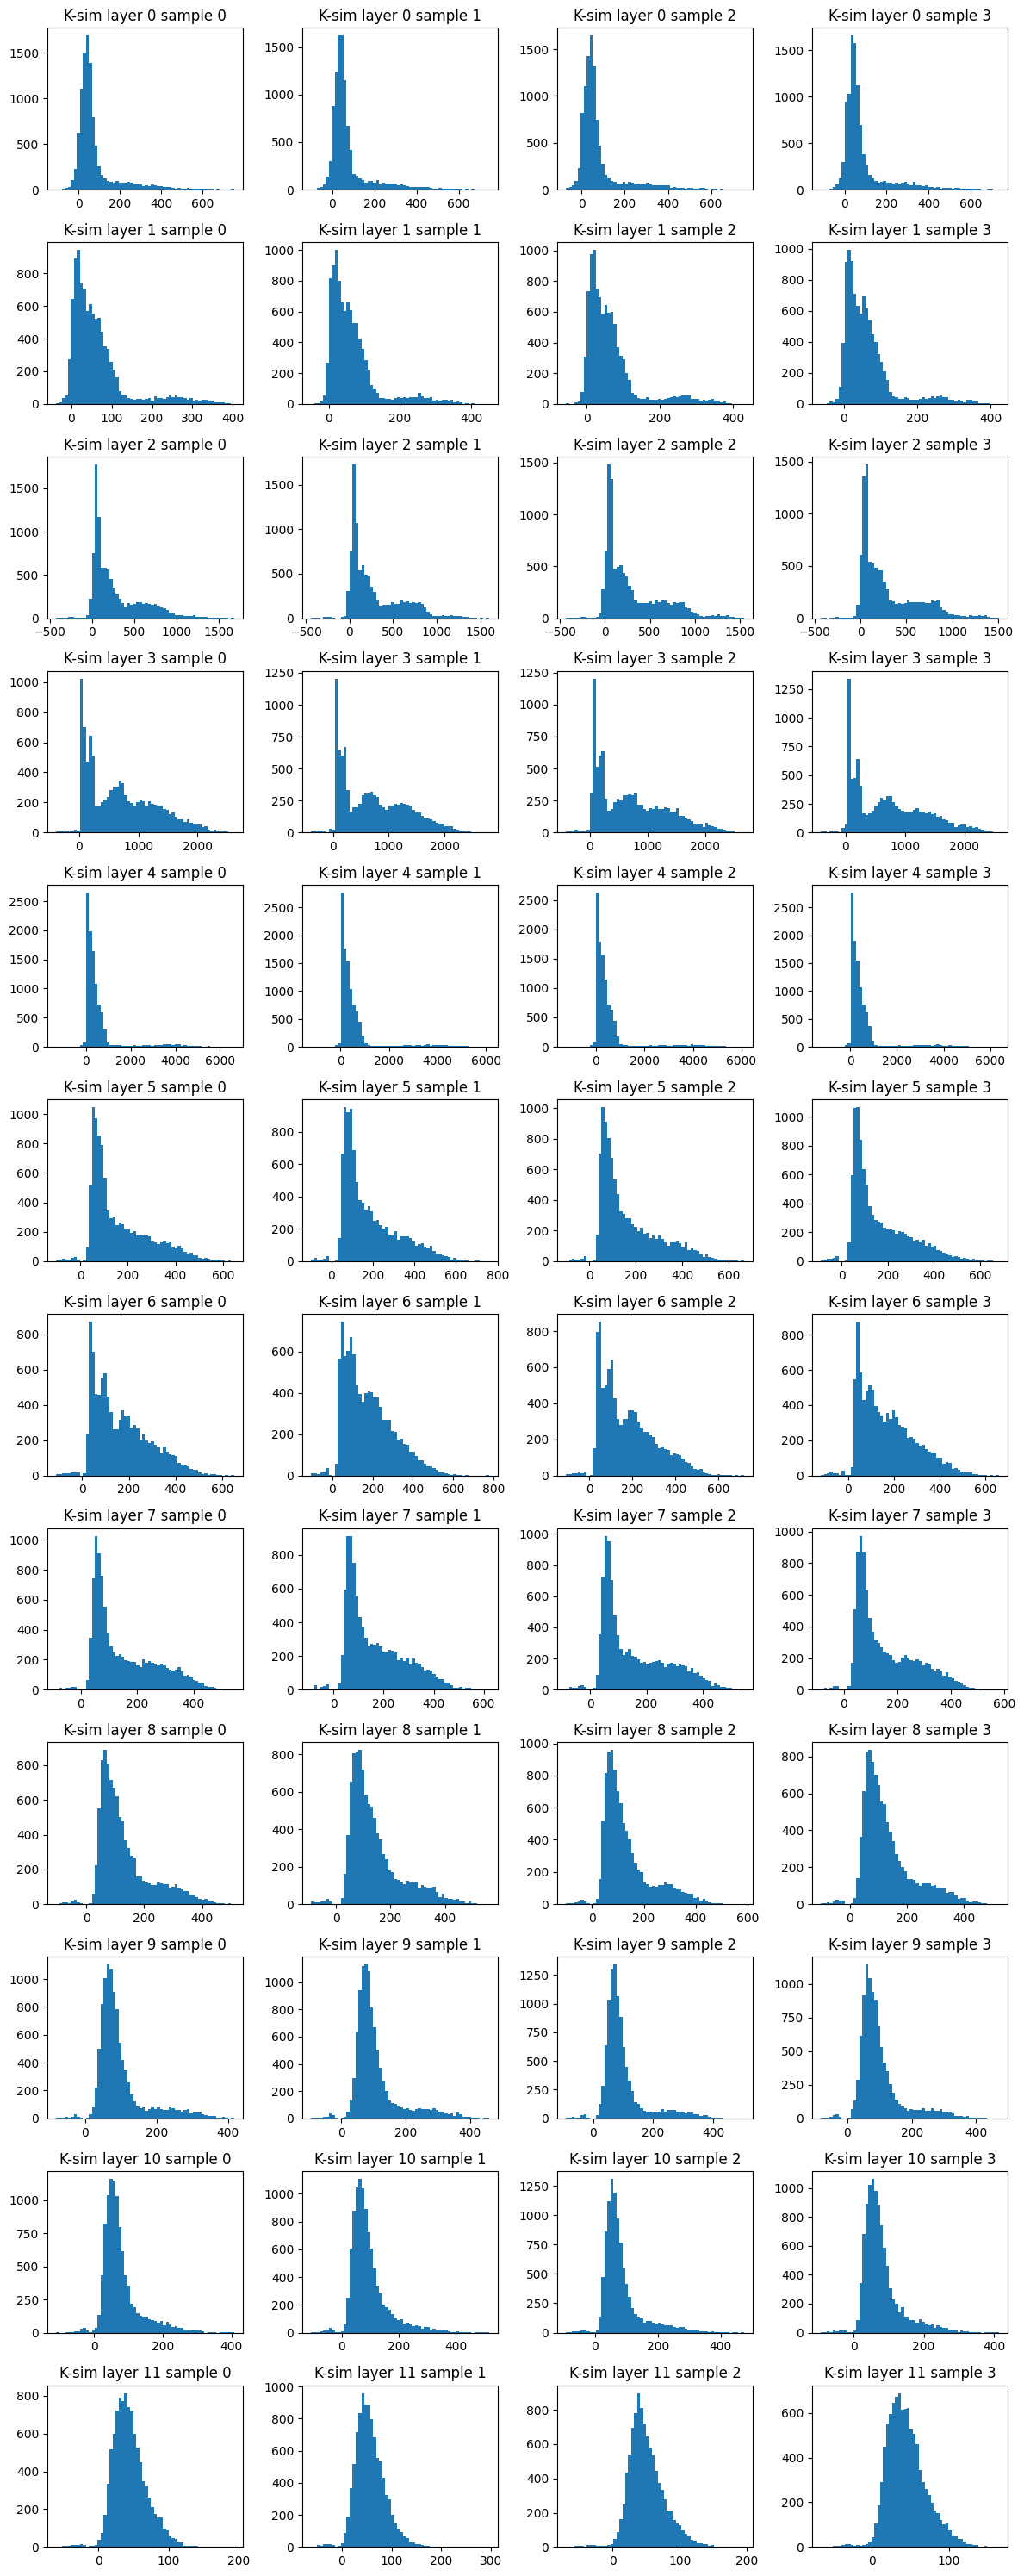

In [178]:
n_sample = 4
n_layer = 12
f, ax = plt.subplots(n_layer, n_sample, figsize=(12, 30))
with torch.no_grad():
    for i in range(n_sample):
        batch = next(batch_iter)
        model_input = {name: t.to(DEVICE) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                         return_tensors="pt",
                                                                                         truncation=True,
                                                                                         max_length=LOSS_RANGE[1]).items()}
        out = model(**model_input)
        for layer in KSIM_OUTPUT_BY_LAYER:
            ax[layer,i].hist(KSIM_OUTPUT_BY_LAYER[layer], bins=60)
            ax[layer,i].set_title(f"K-sim layer {layer} sample {i}")
f.tight_layout()

In [ ]:
n_sample = 4
n_layer = 12
f, ax = plt.subplots(n_layer, n_sample, figsize=(12, 30))
with torch.no_grad():
    for i in range(n_sample):
        batch = next(batch_iter)
        model_input = {name: t.to(DEVICE) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                         return_tensors="pt",
                                                                                         truncation=True,
                                                                                         max_length=LOSS_RANGE[1]).items()}
        out = model(**model_input)
        for layer in KSIM_OUTPUT_BY_LAYER["kwise_other_q_weight"]:
            ax[layer,i].hist(KSIM_OUTPUT_BY_LAYER["kwise_other_q_weight"][layer], bins=60)
            ax[layer,i].set_title(f"Other-k weight layer {layer} sample {i}")
f.tight_layout()

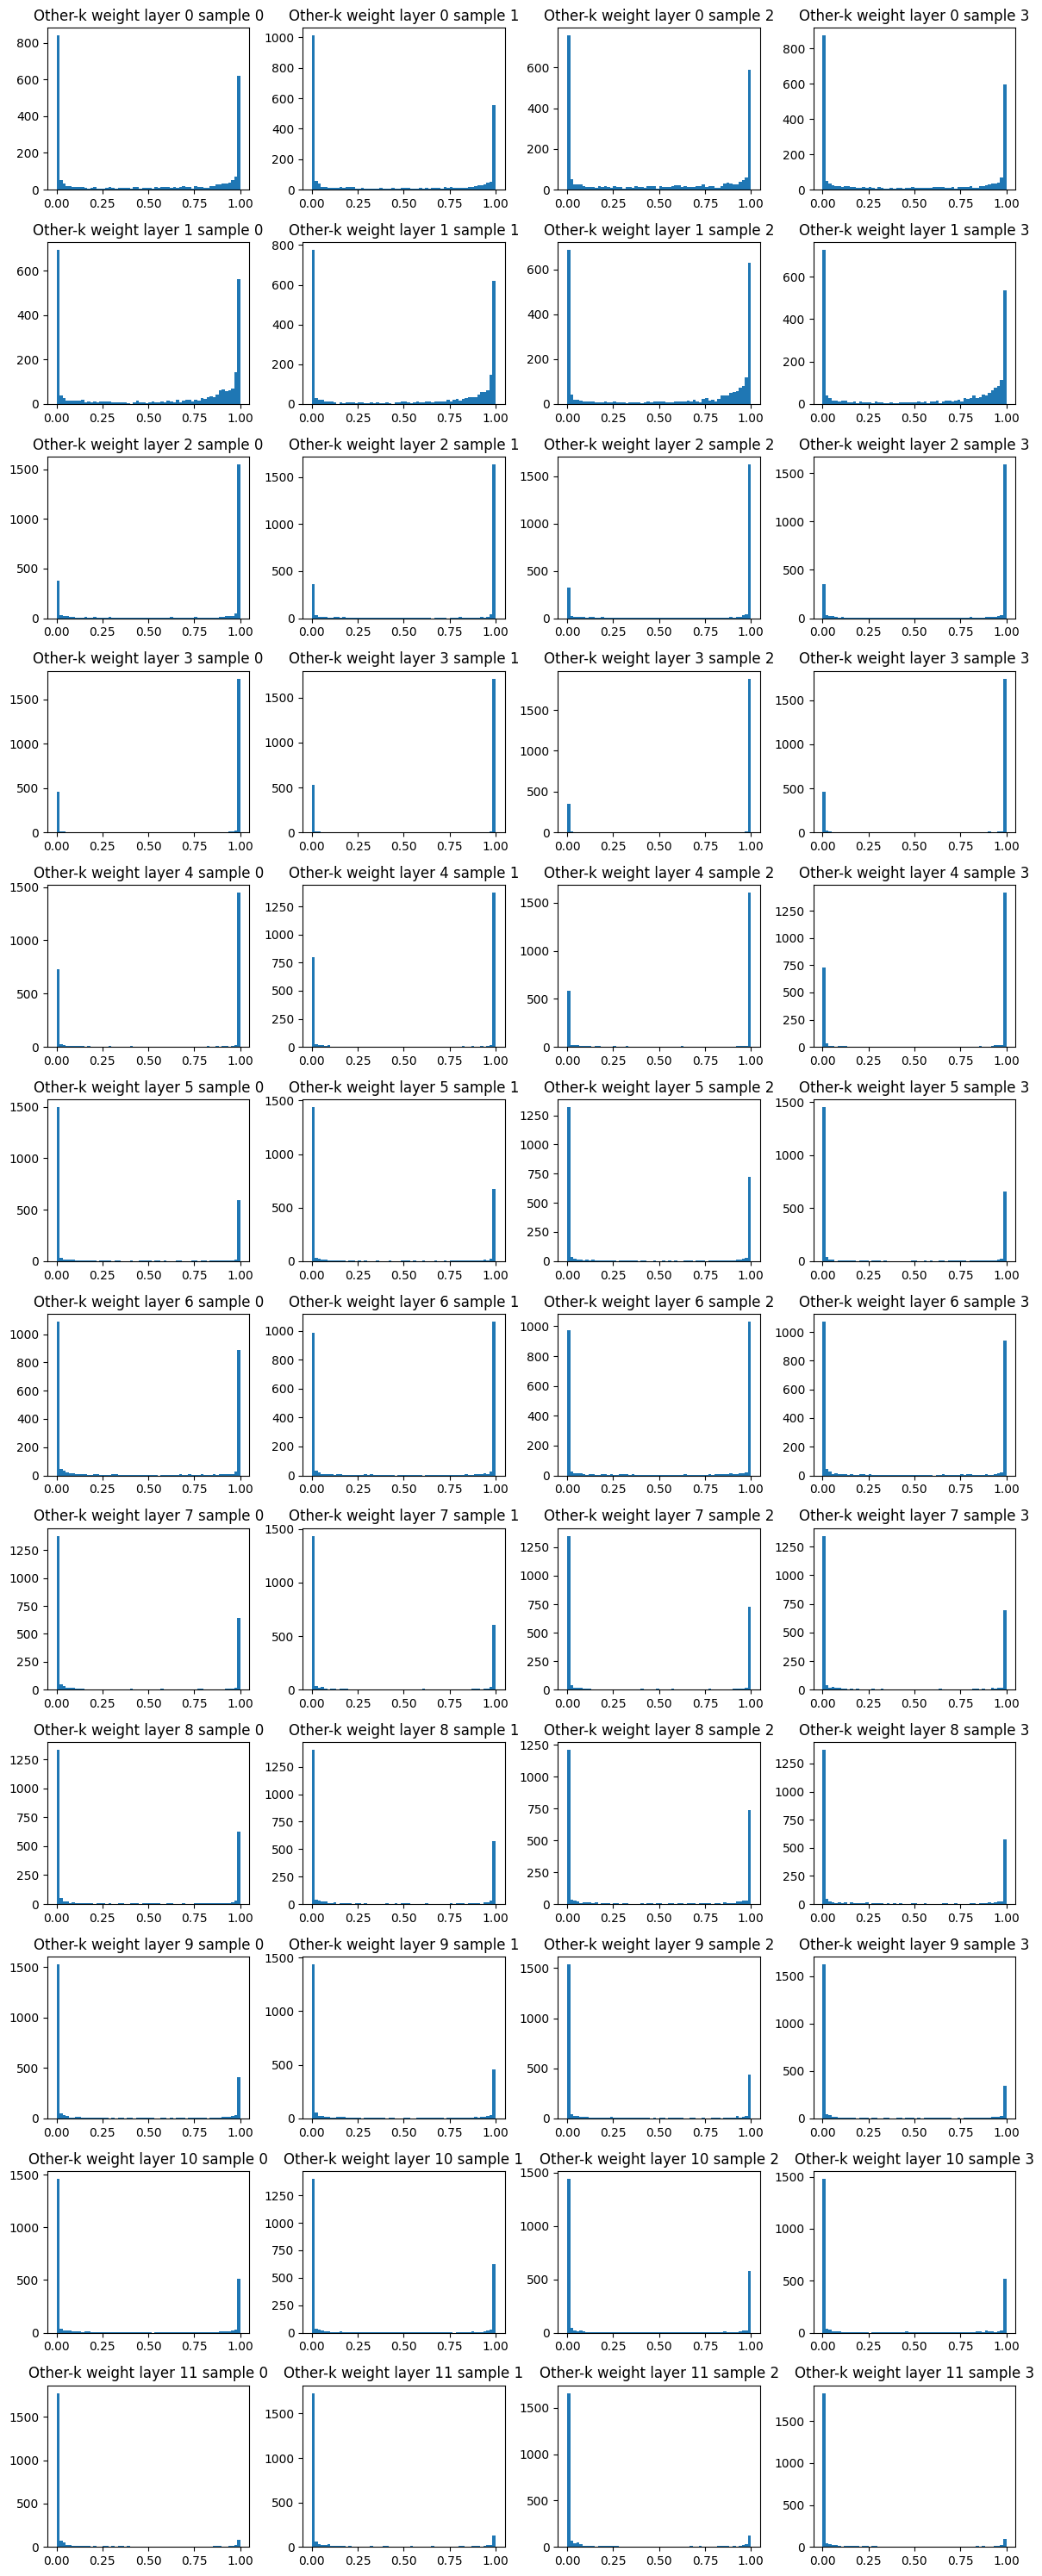

In [213]:
n_sample = 4
n_layer = 12
f, ax = plt.subplots(n_layer, n_sample, figsize=(12, 30))
with torch.no_grad():
    for i in range(n_sample):
        batch = next(batch_iter)
        model_input = {name: t.to(DEVICE) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                         return_tensors="pt",
                                                                                         truncation=True,
                                                                                         max_length=LOSS_RANGE[1]).items()}
        out = model(**model_input)
        for layer in KSIM_OUTPUT_BY_LAYER["kwise_other_k_weight"]:
            ax[layer,i].hist(KSIM_OUTPUT_BY_LAYER["kwise_other_k_weight"][layer], bins=60)
            ax[layer,i].set_title(f"Other-k weight layer {layer} sample {i}")
f.tight_layout()

In [12]:
batch_size = 1
no_loss_label = -100  # used to make CE loss ignore this element
indices, = np.where(l > LOSS_RANGE[1])
nlls = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(np.array_split(indices, len(indices) // batch_size))):
        model_input = {name: t.to(DEVICE) for name, t in tokenizer.batch_encode_plus(split[batch]['text'],
                                                                                     return_tensors="pt",
                                                                                     truncation=True,
                                                                                     max_length=LOSS_RANGE[1]).items()}
        labels = model_input['input_ids'].clone()
        labels[:,:LOSS_RANGE[0]] = no_loss_label
        labels[:,LOSS_RANGE[1]:] = no_loss_label
        out = model(**model_input, labels=labels)  # forward pass handles predicted token time shift
        nlls += [out.loss]
ppl = torch.exp(torch.stack(nlls).mean())

  0%|          | 0/7626 [00:00<?, ?it/s]

In [9]:
ppl  # published result is 37.50

tensor(37.0557, device='cuda:0')

In [13]:
ppl  # computed over LOSS_RANGE (lower since tokens we compute loss for now have more prior information)

tensor(29.7449, device='cuda:0')

### Apply to MQA (GPTBigCode)